In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

# Configuration
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔹 Running on device: {device}")

🔹 Running on device: cuda


In [ ]:
class CausalDiscoveryLayer(nn.Module):
    def __init__(self, num_variables: int, hidden_dim: int = 32):
        super().__init__()
        self.num_variables = num_variables
        # Learnable parameter for adjacency matrix
        self.causal_logits = nn.Parameter(torch.randn(num_variables, num_variables) * 0.1)
        self.causal_transform = nn.Sequential(
            nn.Linear(num_variables, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_variables)
        )

    def get_causal_adjacency(self, temperature: float = 0.7):
        """Computes the soft adjacency matrix using sigmoid"""
        scaled_logits = self.causal_logits / temperature
        # Mask diagonal to prevent self-loops
        eye = torch.eye(self.num_variables, device=scaled_logits.device).bool()
        scaled_logits = scaled_logits.masked_fill(eye, float('-inf'))
        return torch.sigmoid(scaled_logits)

    def apply_causal_mask(self, x, causal_adj):
        """Applies the learned causal structure to the input features"""
        B, T, V = x.shape
        causal_features = torch.zeros_like(x)
        for t in range(1, T):
            prev = x[:, t-1, :]
            causal_features[:, t, :] = torch.matmul(prev, causal_adj)
        causal_features[:, 0, :] = x[:, 0, :]
        return causal_features

    def forward(self, x):
        causal_adj = self.get_causal_adjacency()
        causal_features = self.apply_causal_mask(x, causal_adj)
        B, T, V = x.shape
        enhanced = self.causal_transform(causal_features.view(-1, V)).view(B, T, V)
        return causal_adj, enhanced

In [ ]:
class CausalAttention(nn.Module):
    def __init__(self, d_model: int, num_heads: int = 4):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, _ = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        # Causal Mask (Standard Transformer Mask for time sequence)
        mask = torch.tril(torch.ones(T, T, device=x.device)).unsqueeze(0).unsqueeze(0)
        scores = scores.masked_fill(mask == 0, -1e9)

        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(B, T, self.d_model)
        return self.out_proj(out), attn

class CDTransformer(nn.Module):
    def __init__(self, num_variables, d_model=64, num_heads=4, num_layers=2):
        super().__init__()
        self.causal_discovery = CausalDiscoveryLayer(num_variables)
        self.input_projection = nn.Linear(num_variables, d_model)
        self.layers = nn.ModuleList([CausalAttention(d_model, num_heads) for _ in range(num_layers)])
        self.output_projection = nn.Linear(d_model, 1)

    def forward(self, x):
        # 1. Causal Discovery Phase
        adj, enhanced = self.causal_discovery(x)
        # 2. Fusion (50% Original + 50% Causal Enhanced)
        x_proj = self.input_projection(0.5 * x + 0.5 * enhanced)

        # 3. Transformer Processing
        attns = []
        for layer in self.layers:
            out, attn = layer(x_proj)
            x_proj = x_proj + out # Residual connection
            attns.append(attn)

        # Return prediction (last time step), adjacency matrix, and attention maps
        return self.output_projection(x_proj[:, -1, :]), adj, attns

In [ ]:
def create_sliding_dataset(ticker, seq_len=30):
    print(f"\n📥 Downloading data for {ticker}...")
    df = yf.download(ticker, start='2020-01-01', end='2024-12-31', progress=False)

    # Feature Engineering
    df['MA5'] = df['Close'].rolling(5).mean()
    df['MA20'] = df['Close'].rolling(20).mean()
    df['Returns'] = df['Close'].pct_change()
    features = ['Close', 'Open', 'High', 'Low', 'Volume', 'MA5', 'MA20', 'Returns']
    df = df[features].dropna()

    # Normalization
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)

    # --- SLIDING WINDOW LOGIC ---
    X, y = [], []
    for i in range(len(scaled_data) - seq_len):
        # Window: i to i+30
        window = scaled_data[i : i + seq_len]
        # Target: i+30 (Close price)
        label = scaled_data[i + seq_len, 0]
        X.append(window)
        y.append(label)
    # ----------------------------

    X = np.array(X)
    y = np.array(y)

    # Train/Test Split (80/20)
    split_idx = int(0.8 * len(X))
    X_train, X_test = torch.FloatTensor(X[:split_idx]), torch.FloatTensor(X[split_idx:])
    y_train, y_test = torch.FloatTensor(y[:split_idx]), torch.FloatTensor(y[split_idx:])

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

    print(f"   ✅ Created Sliding Windows: Train size={len(X_train)}, Test size={len(X_test)}")
    return train_loader, test_loader, scaler, features

In [ ]:
def plot_metrics_panel(y_true, y_pred, ticker, metrics):
    """Plots 4 detailed performance charts"""
    errors = y_true - y_pred
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    plt.suptitle(f"Performance Analysis: {ticker}", fontsize=16, fontweight='bold')

    # 1. Actual vs Predicted
    axes[0,0].plot(y_true[-100:], label='Actual', color='blue', alpha=0.6)
    axes[0,0].plot(y_pred[-100:], label='Predicted', color='red', linestyle='--')
    axes[0,0].set_title("Actual vs Predicted (Last 100 days)")
    axes[0,0].legend()
    info_text = f"MAE: {metrics['MAE']:.3f}\nRMSE: {metrics['RMSE']:.3f}\nR2: {metrics['R2']:.3f}"
    axes[0,0].text(0.05, 0.95, info_text, transform=axes[0,0].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    # 2. Error over Time
    axes[0,1].plot(errors, color='orange', linewidth=0.8)
    axes[0,1].axhline(0, color='black')
    axes[0,1].set_title("Error Variance over Time")

    # 3. Error Distribution
    sns.histplot(errors, kde=True, ax=axes[1,0], color='purple')
    axes[1,0].set_title("Residual Distribution")

    # 4. Residuals vs Actual
    axes[1,1].scatter(y_true, errors, alpha=0.3, color='green')
    axes[1,1].axhline(0, color='red', linestyle='--')
    axes[1,1].set_title("Residuals vs Actual Values")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_causal_heatmap(model, features, ticker):
    """Visualizes the learned Causal Matrix"""
    model.eval()
    with torch.no_grad():
        adj = model.causal_discovery.get_causal_adjacency().cpu().numpy()

    plt.figure(figsize=(9, 7))
    sns.heatmap(adj, xticklabels=features, yticklabels=features, cmap="Blues", annot=True, fmt=".2f")
    plt.title(f"Causal Discovery Matrix (Invention) - {ticker}")
    plt.show()

def run_intervention_analysis(model, test_loader, features, scaler, base_mae, ticker):
    """Intervention Analysis: Sensitivity of each variable"""
    print(f"   🔎 Running Intervention Analysis for {ticker}...")
    effects = {}

    # Aggregate all test data
    X_test_all, y_test_all = [], []
    for bx, by in test_loader:
        X_test_all.append(bx); y_test_all.append(by)
    X_test = torch.cat(X_test_all).to(device)
    y_test = torch.cat(y_test_all).numpy()

    for i, f_name in enumerate(features):
        # Clone and zero-out variable i
        X_mod = X_test.clone()
        X_mod[:, :, i] = 0.0

        with torch.no_grad():
            p_mod, _, _ = model(X_mod)

        # Inverse transform
        p_real = scaler.inverse_transform(np.c_[p_mod.cpu().numpy(), np.zeros((len(p_mod), len(features)-1))])[:, 0]
        y_real = scaler.inverse_transform(np.c_[y_test, np.zeros((len(y_test), len(features)-1))])[:, 0]

        new_mae = mean_absolute_error(y_real, p_real)
        effects[f_name] = new_mae - base_mae # Increase in error

    plt.figure(figsize=(10, 5))
    s = pd.Series(effects).sort_values()
    sns.barplot(x=s.values, y=s.index, palette="viridis")
    plt.title(f"Intervention Analysis (Feature Sensitivity) - {ticker}")
    plt.xlabel("MAE Increase when variable is removed (Higher is more important)")
    plt.show()


📥 Downloading data for GOOGL...
   ✅ Created Sliding Windows: Train size=966, Test size=242
   🚀 Starting training for GOOGL...
      Epoch 10: Loss = 0.00602
      Epoch 20: Loss = 0.00534


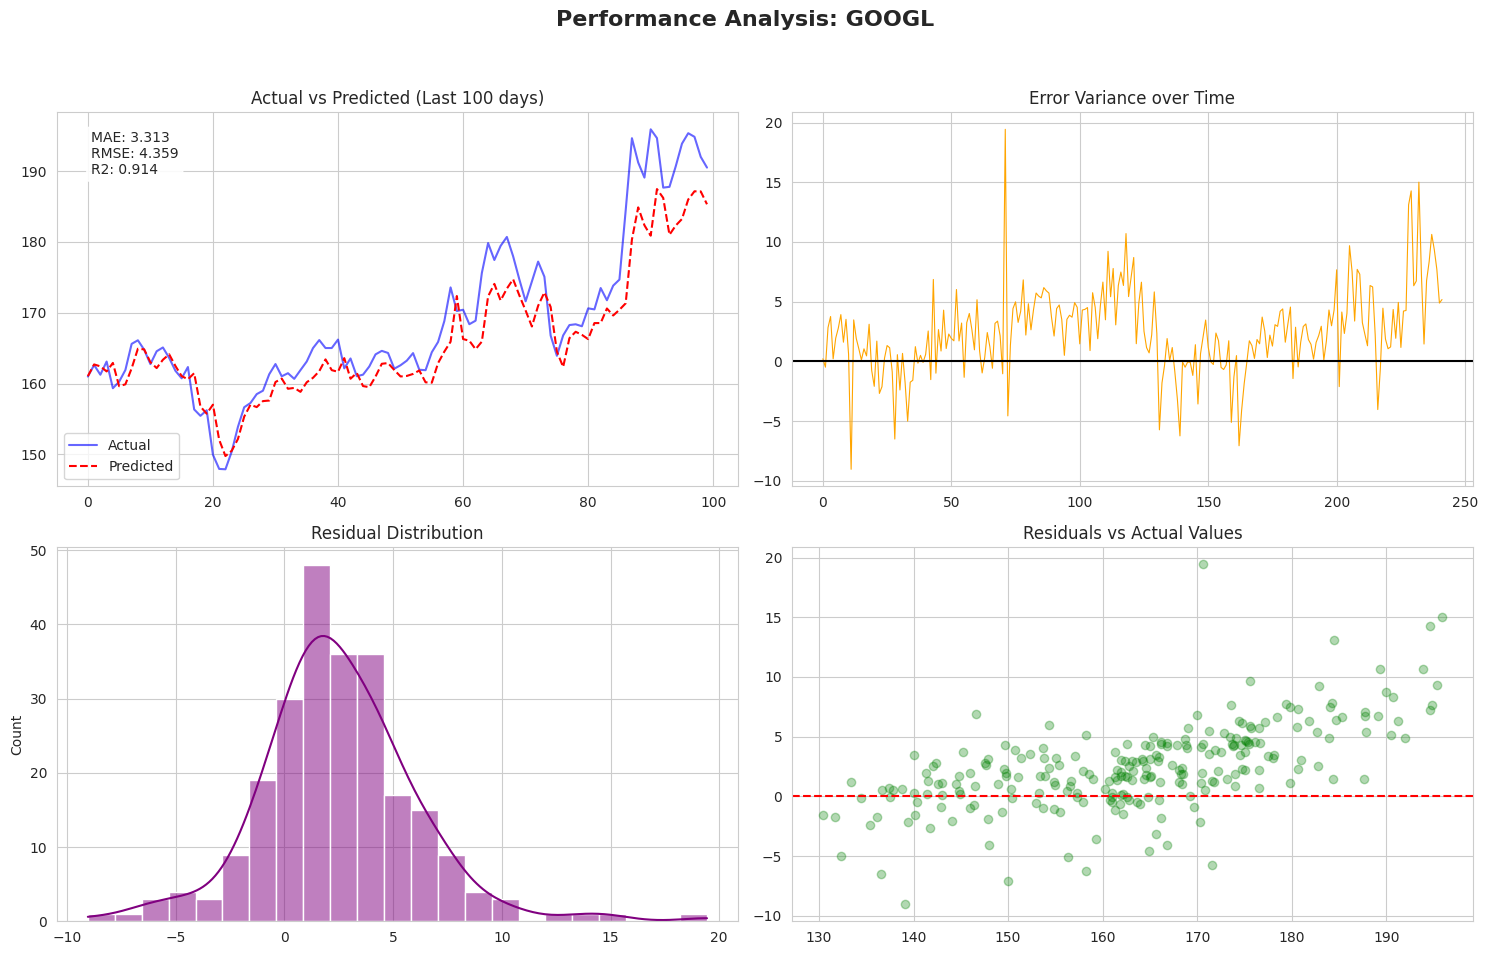

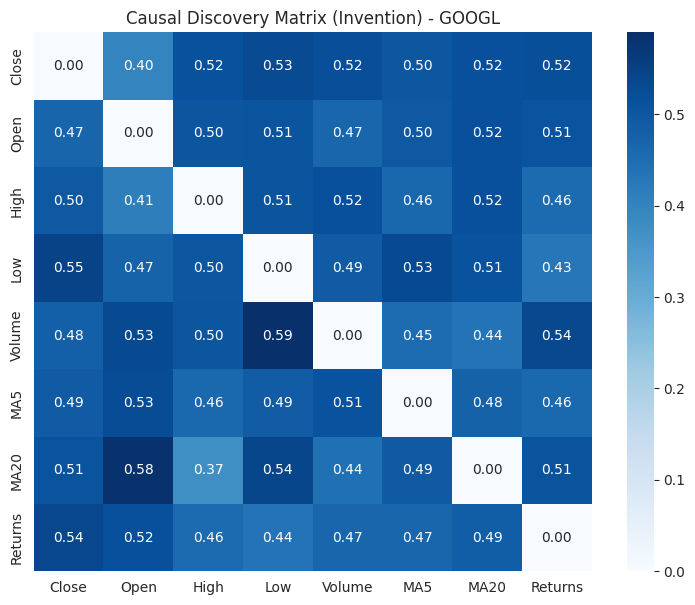

   🔎 Running Intervention Analysis for GOOGL...


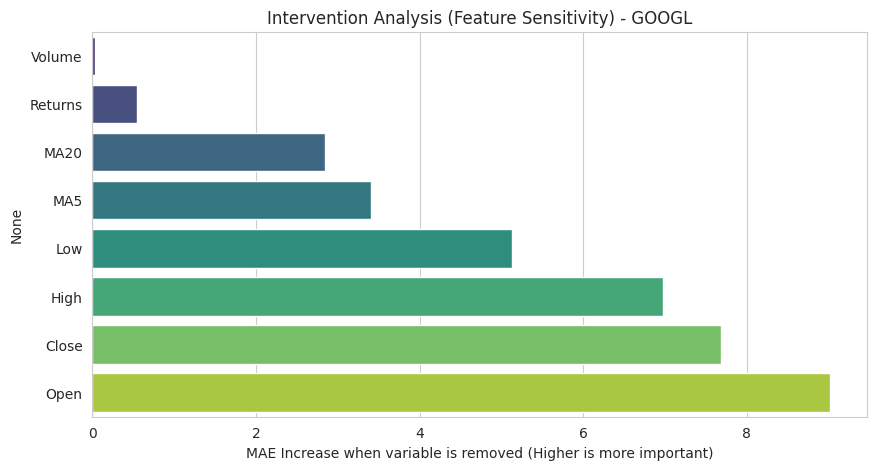


📥 Downloading data for AAPL...
   ✅ Created Sliding Windows: Train size=966, Test size=242
   🚀 Starting training for AAPL...
      Epoch 10: Loss = 0.00639
      Epoch 20: Loss = 0.00505


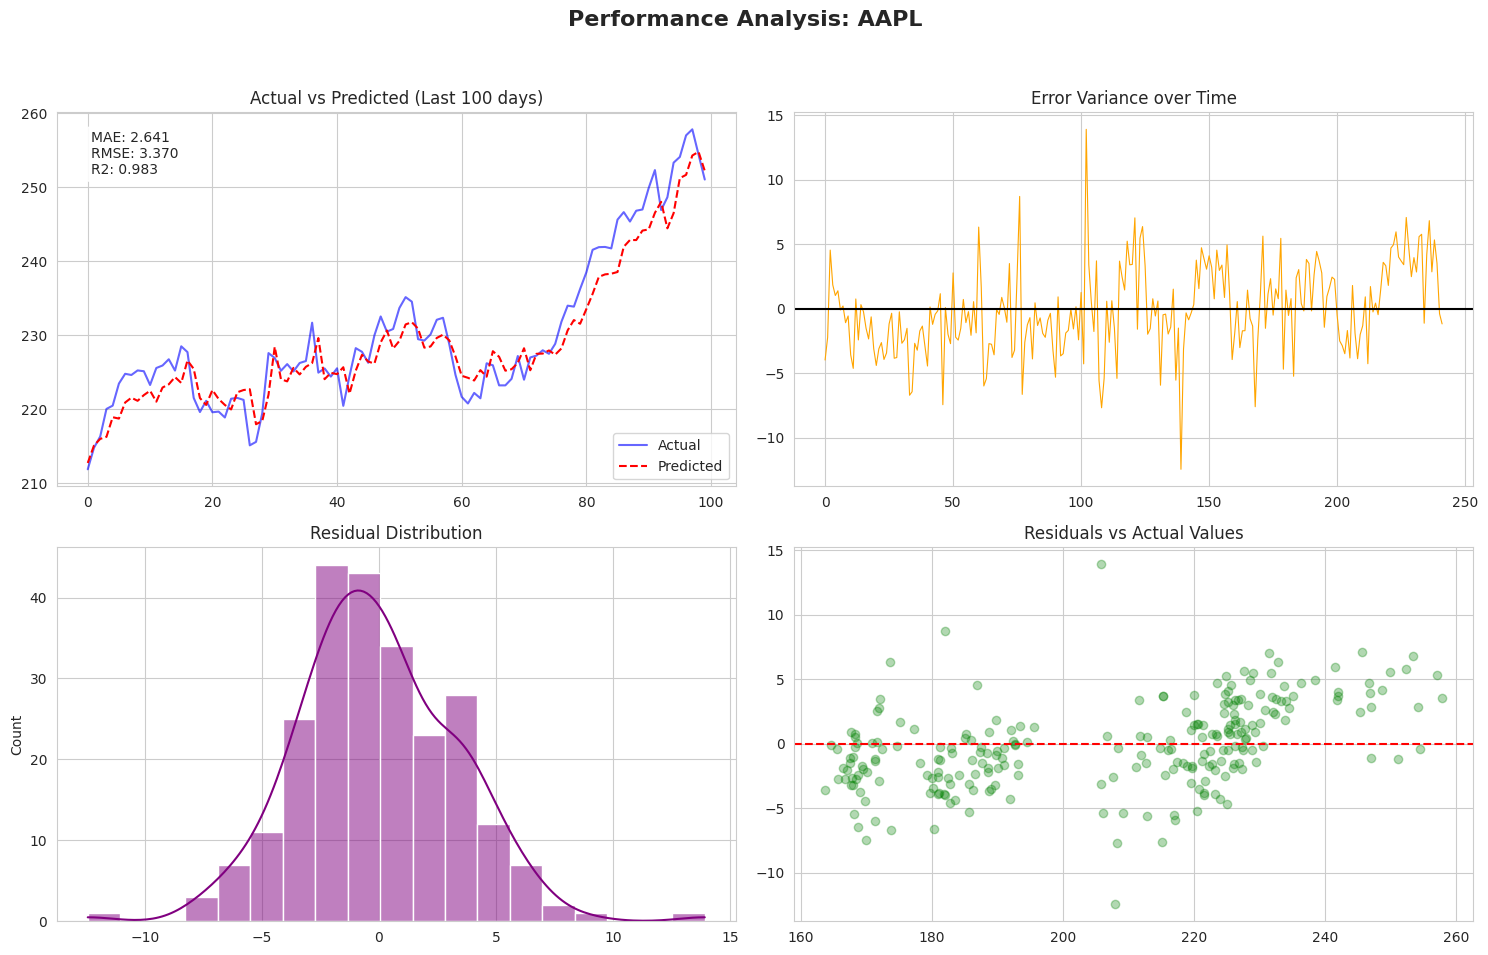

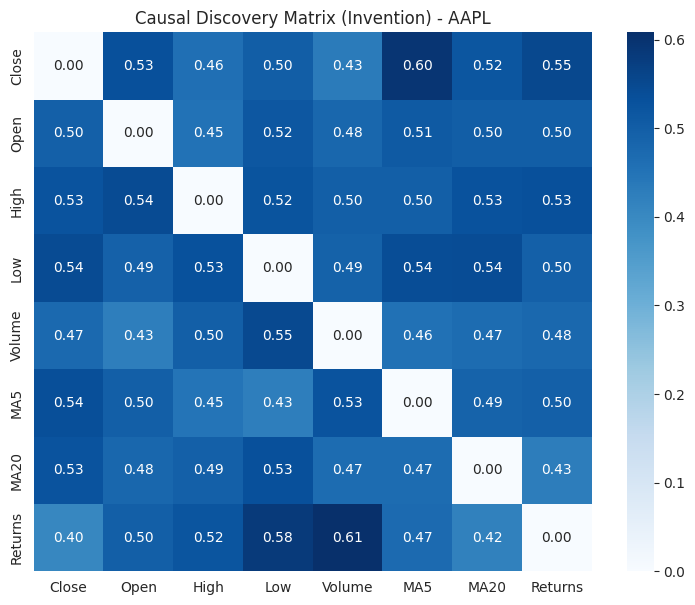

   🔎 Running Intervention Analysis for AAPL...


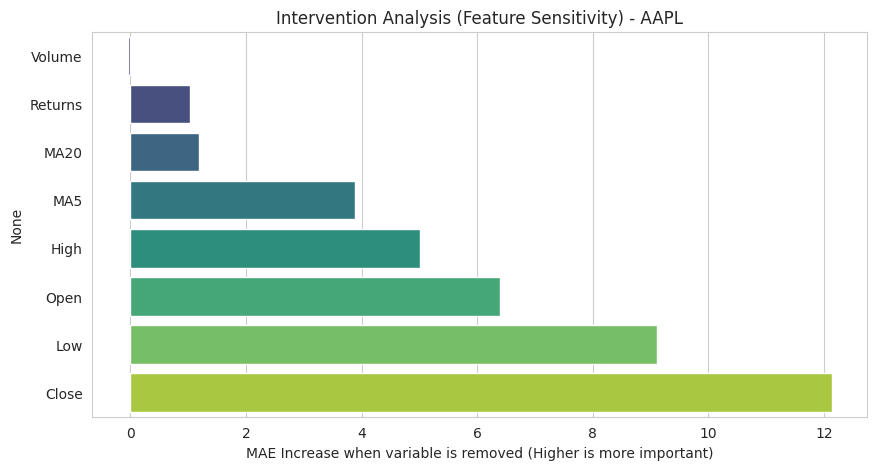


📥 Downloading data for TSLA...
   ✅ Created Sliding Windows: Train size=966, Test size=242
   🚀 Starting training for TSLA...
      Epoch 10: Loss = 0.01671
      Epoch 20: Loss = 0.01335


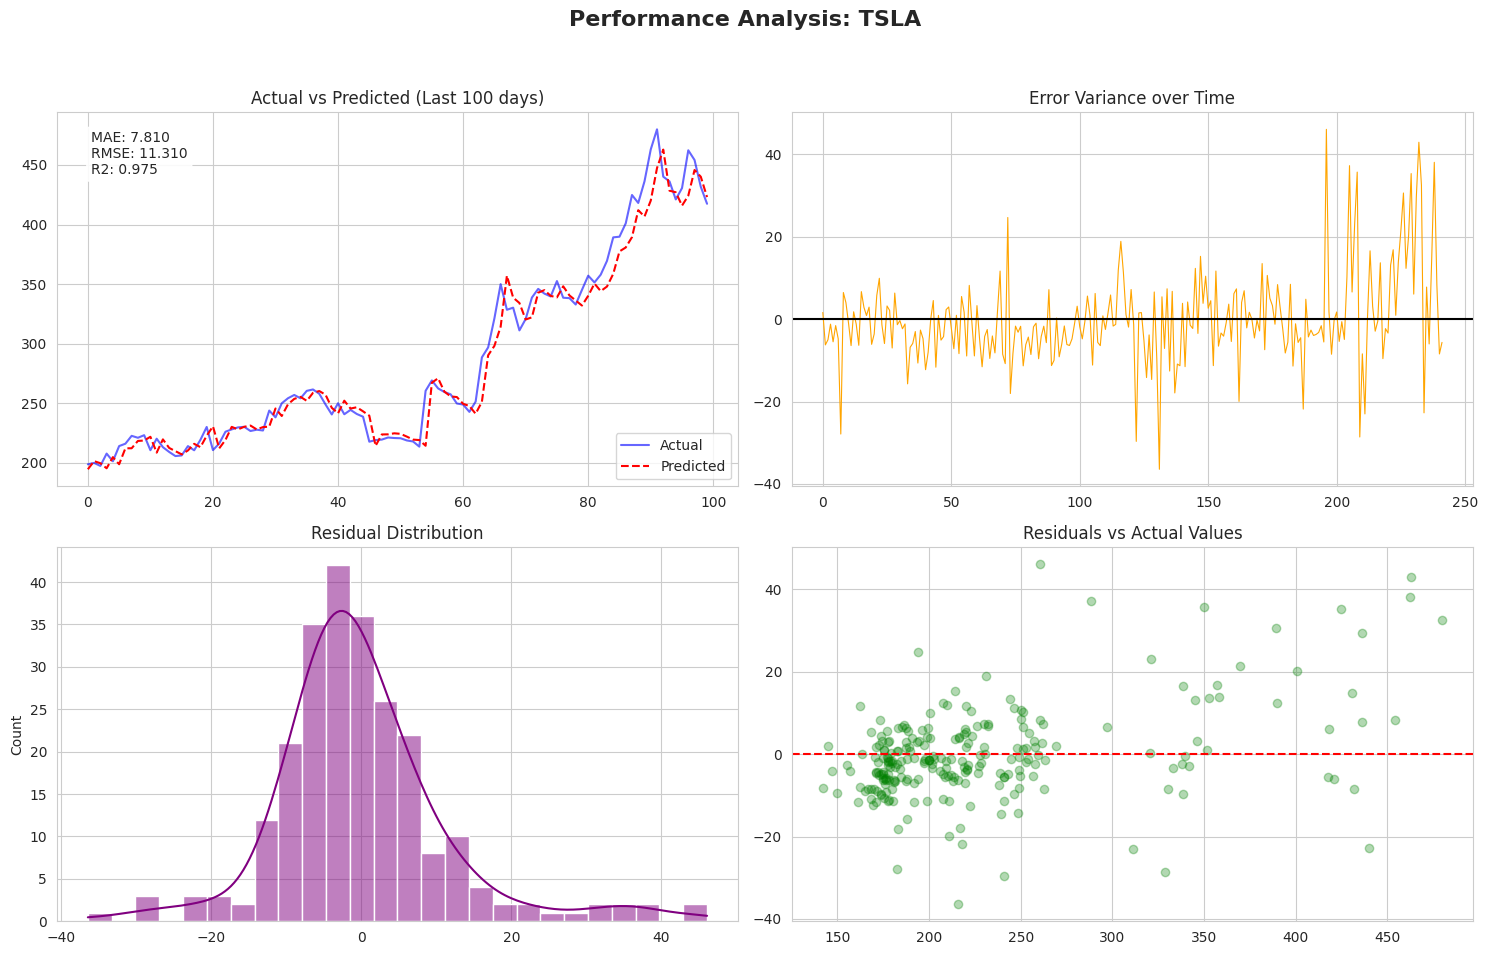

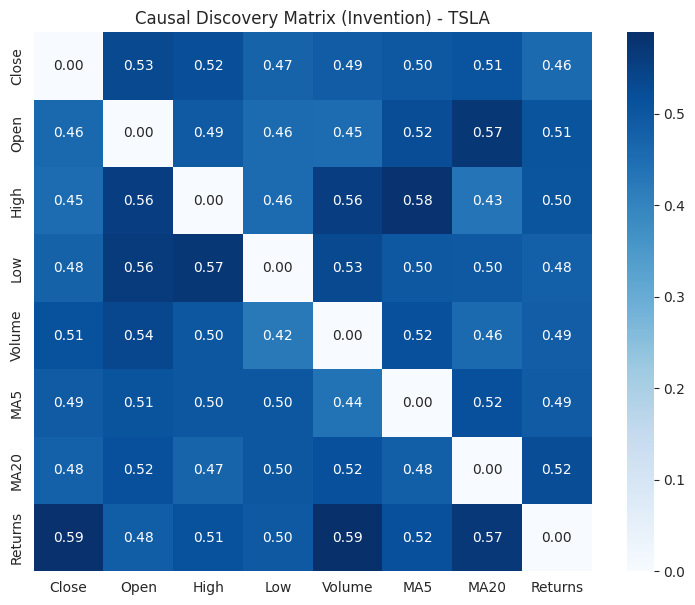

   🔎 Running Intervention Analysis for TSLA...


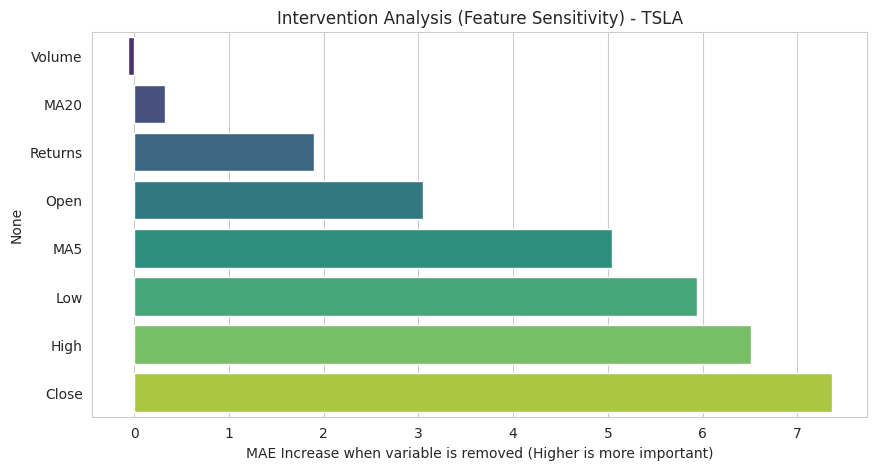


📊 --- PERFORMANCE SUMMARY ---
  Ticker       MAE       RMSE        R2
0  GOOGL  3.312730   4.358939  0.913849
1   AAPL  2.640721   3.370098  0.982573
2   TSLA  7.810251  11.309705  0.974915


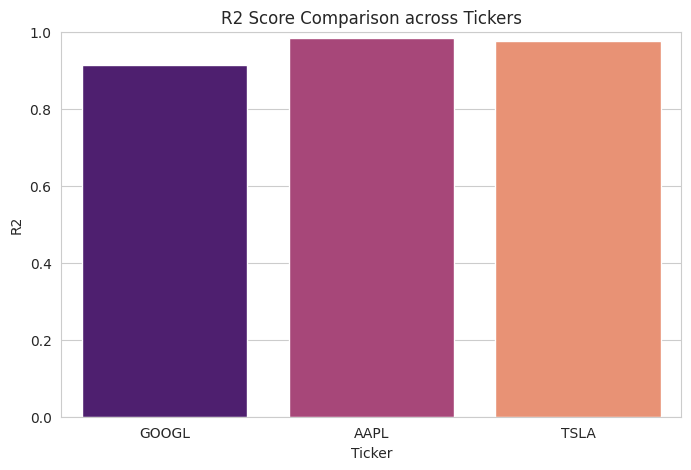

In [ ]:
tickers = ['GOOGL', 'AAPL', 'TSLA']
results_summary = []

for ticker in tickers:
    # A. PREPARE DATA
    train_loader, test_loader, scaler, features = create_sliding_dataset(ticker)

    # B. INIT & TRAIN
    model = CDTransformer(num_variables=len(features)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    print(f"   🚀 Starting training for {ticker}...")
    model.train()
    for epoch in range(25): # 25 Epochs
        total_loss = 0
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            pred, _, _ = model(bx)
            loss = F.mse_loss(pred.squeeze(), by)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch+1) % 10 == 0:
            print(f"      Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.5f}")

    # C. EVALUATE & VISUALIZE
    model.eval()
    preds, actuals = [], []
    with torch.no_grad():
        for bx, by in test_loader:
            p, _, _ = model(bx.to(device))
            preds.append(p.cpu().numpy())
            actuals.append(by.numpy())

    # Inverse Transform
    preds = np.concatenate(preds).flatten()
    actuals = np.concatenate(actuals).flatten()

    dummy_p = np.zeros((len(preds), len(features))); dummy_p[:, 0] = preds
    dummy_a = np.zeros((len(actuals), len(features))); dummy_a[:, 0] = actuals

    y_pred_real = scaler.inverse_transform(dummy_p)[:, 0]
    y_true_real = scaler.inverse_transform(dummy_a)[:, 0]

    # Calculate Metrics
    mae = mean_absolute_error(y_true_real, y_pred_real)
    rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))
    r2 = r2_score(y_true_real, y_pred_real)
    results_summary.append({"Ticker": ticker, "MAE": mae, "RMSE": rmse, "R2": r2})

    # 1. Plot Metrics Panel
    plot_metrics_panel(y_true_real, y_pred_real, ticker, {"MAE": mae, "RMSE": rmse, "R2": r2})

    # 2. Plot Causal Impact
    plot_causal_heatmap(model, features, ticker)

    # 3. Run Intervention Analysis
    run_intervention_analysis(model, test_loader, features, scaler, mae, ticker)

# --- FINAL COMPARISON ---
print("\n📊 --- PERFORMANCE SUMMARY ---")
df_res = pd.DataFrame(results_summary)
print(df_res)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_res, x='Ticker', y='R2', palette='magma')
plt.title("R2 Score Comparison across Tickers")
plt.ylim(0, 1)
plt.show()